Trong bài tập này, chúng ta sẽ xây dựng 1 model Sentiment Analysis ứng dụng cấu trúc LSTM, dựa trên tập dữ liệu Movie Review của Cornell. Model sẽ có chức năng phân loại cảm xúc đánh giá (tích cực - positive, tiêu cực - negative) dựa trên những đánh giá của khán giả với những bộ phim mà họ đã xem.

## 1. Import các thư viện cần thiết

In [2]:
import os
import random
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

from string import punctuation
from torch.utils.data import TensorDataset, DataLoader

random.seed(42)
torch.manual_seed(42)

## 2. Load data

Tập dữ liệu Movie Review gồm 2 file text "rt-polarity.pos" và "rt-polarity.neg" tương ứng với các đánh giá tích cực và tiêu cực. Mỗi 1 dòng là 1 câu đánh giá

Ta xây dựng hàm "read_file" dùng để đọc các file text:

In [3]:
def read_file(path):
    with open(path, 'r', encoding='Windows-1252') as f:
        data = f.read()

    return data

Và hàm "read_data" dùng để đọc dữ liệu. Hàm này sẽ trả về 2 mảng "reviews" và "labels". Trong đó mảng "reviews" chứa toàn bộ các đánh giá dưới dạng chuỗi string, mảng label chứa các số nguyên 0 và 1, tương ứng với các đánh giá tiêu cực và tích cực

In [ ]:
def read_data(dir):
    # YOUR CODE HERE

data_dir = 'Data/rt-polaritydata'
reviews, labels = read_data(data_dir)
print(len(reviews))
print(reviews[0])
print(labels[0])

In [5]:
# DON'T WRITE HERE

10664
simplistic , silly and tedious . 
0


## 3. Tiền xử lý data

Ta xây dựng hàm "preprocess_data" với chức năng: Chuyển đổi các đánh giá về dạng chữ viết thường, loại bỏ các dấu câu.

In [ ]:
def preprocess_data(reviews):
    # YOUR CODE HERE

reviews = preprocess_data(reviews)
print(reviews[0])

In [6]:
# DON'T WRITE HERE

simplistic   silly and tedious   


Tạo mảng vocab, chứa toàn bộ các từ có xuất hiện trong các câu đánh giá. Mỗi từ trong vocab là duy nhất và được sắp xếp theo thứ tự tăng dần

In [ ]:
def create_vocab(reviews):
    # YOUR CODE HERE
    
vocab = create_vocab(reviews)
print(len(vocab))
print(vocab)

In [7]:
# DON'T WRITE HERE

18404
['00', '000', '007', '1', '10', '100', '101', '102', '103', '104', '105', '10th', '11', '110', '112', '117', '11th', '12', '120', '123', '125', '127', '129', '12th', '13', '133', '13th', '14', '140', '146', '15', '15th', '16', '163', '168', '17', '170', '179', '1790', '18', '180', '1873', '1899', '18th', '19', '1915', '1920', '1930s', '1933', '1934', '1937', '1938', '1940s', '1949', '1950', '1950s', '1952', '1953', '1954', '1955', '1957', '1958', '1959', '1960', '1960s', '1962', '1967', '1970', '1970s', '1971', '1972', '1973', '1975', '1978', '1979', '1980', '1980s', '1982', '1983', '1984', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1997', '1998', '1999', '19th', '2', '20', '2000', '2001', '2002', '20th', '21', '21st', '22', '24', '2455', '25', '2525', '25s', '26', '270', '28k', '295', '3', '30', '300', '3000', '30s', '33', '37', '3d', '4', '40', '400', '401', '40s', '42', '45', '451', '48', '49', '4ever', '4th', '4w', '5', '50', '500', '50s'

Xây dựng 1 dictionary "word2int" gồm các cặp key:value, với các key là các từ trong vocab, value là vị trí của từ đó trong vocab. Dictionary này sẽ được sử dụng trong việc chuyển đổi các từ trong câu thành các số nguyên tương ứng. Chú ý: Vị trí của từ bắt đầu từ 1 trở đi. Giá trị 0 được sử dụng cho từ khóa "padding" sau này.

In [ ]:
# YOUR CODE HERE

print(word2int)

In [8]:
# DON'T WRITE HERE

{'00': 1, '000': 2, '007': 3, '1': 4, '10': 5, '100': 6, '101': 7, '102': 8, '103': 9, '104': 10, '105': 11, '10th': 12, '11': 13, '110': 14, '112': 15, '117': 16, '11th': 17, '12': 18, '120': 19, '123': 20, '125': 21, '127': 22, '129': 23, '12th': 24, '13': 25, '133': 26, '13th': 27, '14': 28, '140': 29, '146': 30, '15': 31, '15th': 32, '16': 33, '163': 34, '168': 35, '17': 36, '170': 37, '179': 38, '1790': 39, '18': 40, '180': 41, '1873': 42, '1899': 43, '18th': 44, '19': 45, '1915': 46, '1920': 47, '1930s': 48, '1933': 49, '1934': 50, '1937': 51, '1938': 52, '1940s': 53, '1949': 54, '1950': 55, '1950s': 56, '1952': 57, '1953': 58, '1954': 59, '1955': 60, '1957': 61, '1958': 62, '1959': 63, '1960': 64, '1960s': 65, '1962': 66, '1967': 67, '1970': 68, '1970s': 69, '1971': 70, '1972': 71, '1973': 72, '1975': 73, '1978': 74, '1979': 75, '1980': 76, '1980s': 77, '1982': 78, '1983': 79, '1984': 80, '1986': 81, '1987': 82, '1988': 83, '1989': 84, '1990': 85, '1991': 86, '1992': 87, '1993':

Trong quá trình training, ta cần có 3 tập data train, test và validation, do đó ta sẽ chia tập data thành 3 phần: 80% số đánh giá cho tập train, 10% cho tập validation và 10% cho tập test. Chú ý: Xáo trộn tập data trước khi chia để đảm bảo các mẫu được lấy ngẫu nhiên. 

In [ ]:
def split_data(reviews, labels):
    # Shuffle data
    data = [(review, label) for review, label in zip(reviews, labels)]
    random.shuffle(data)

    reviews = [d[0] for d in data]
    labels = [d[1] for d in data]

    # Split data
    # YOUR CODE HERE
    

    return train_reviews, train_labels, valid_reviews, valid_labels, test_reviews, test_labels

train_reviews, train_labels, valid_reviews, valid_labels, test_reviews, test_labels = split_data(reviews, labels)
print(len(train_reviews))
print(len(valid_reviews))
print(len(test_reviews))

In [9]:
# DON'T WRITE HERE

8531
1066
1067


Chuyển đổi các từ trong các câu đánh giá sang dạng số nguyên tương ứng vị trí của từ đó trong vocab.

In [ ]:
def convert_reviews_int(reviews, word2int):
    # YOUR CODE HERE
    

train_reviews = convert_reviews_int(train_reviews, word2int)
valid_reviews = convert_reviews_int(valid_reviews, word2int)
test_reviews = convert_reviews_int(test_reviews, word2int)
print(train_reviews[0])

In [10]:
# DON'T WRITE HERE

[2281, 16317, 5324, 7977, 17813, 9619, 6433, 15047, 7417, 18111, 17970, 16529, 1817, 10691, 17041]


## 4. Phân tích dữ liệu

Khảo sát độ dài của các câu đánh giá

In [ ]:
# YOUR CODE HERE


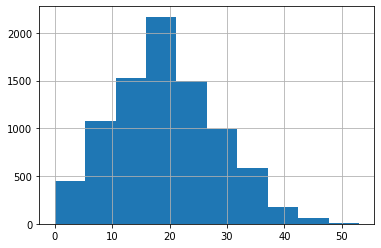

count    8531.000000
mean       19.315321
std         8.919109
min         0.000000
25%        13.000000
50%        19.000000
75%        25.000000
max        53.000000
dtype: float64


In [11]:
# DON'T WRITE HERE

Độ dài trung bình của câu: 19 từ. Đa số các câu có độ dài ít hơn 40 từ.

## 5. Padding / Truncating data và tạo dataloader

Hàm pad_features thực hiện quá trình padding/truncating

In [ ]:
def pad_features(reviews_int, seq_length):
    """
    Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    """
    # YOUR CODE HERE
    
    

seq_length = 40
train_reviews = pad_features(train_reviews, seq_length)
valid_reviews = pad_features(valid_reviews, seq_length)
test_reviews = pad_features(test_reviews, seq_length)
print(train_reviews[0])

In [12]:
# DON'T WRITE HERE

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0  2281 16317  5324  7977 17813  9619  6433 15047  7417 18111 17970
 16529  1817 10691 17041]


Chuyển đổi mảng labels sạng dạng numpy array

In [13]:
# YOUR CODE HERE


Cuối cùng, ta xây dựng dataloader cho các tập dataset, sử dụng class TensorDataset và DatasetLoader có sẵn trong framework Pytorch

In [14]:
# Create Tensor datasets
# YOUR CODE HERE


# Dataloaders
batch_size = 32
# Make sure to SHUFFLE your data
# YOUR CODE HERE



Kiểm tra thử batch data đầu tiên

In [ ]:
# YOUR CODE HERE



In [15]:
# DON'T WRITE HERE

Sample input size:  torch.Size([32, 40])
Sample input: 
 tensor([[    0,     0,     0,  ...,  7207, 11329,  3113],
        [    0,     0,     0,  ...,  6726, 10603, 10447],
        [    0,     0,     0,  ..., 15092, 11139,  6011],
        ...,
        [    0,     0,     0,  ..., 18190, 11139,  7942],
        [    0,     0,     0,  ..., 13858,   666,  5428],
        [    0,     0,     0,  ...,  5557,  1133, 18175]])

Sample label size:  torch.Size([32])
Sample label: 
 tensor([0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 1])


## 6. Xây dựng model

Model class

In [16]:
# YOUR CODE HERE



## 7. Train model

Khởi tạo model

In [ ]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab) + 1  # +1 for the 0 padding
output_size = 1
embedding_dim = 64
hidden_dim = 32
n_layers = 1
train_on_gpu = torch.cuda.is_available()

# YOUR CODE HERE


print(net)

In [17]:
# DON'T WRITE HERE

SentimentLSTM(
  (embedding): Embedding(18405, 64)
  (lstm): LSTM(64, 32, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sig): Sigmoid()
)


/Users/phamvanlong/Projects/TrainTPBank/note_books/venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Định nghĩa loss function và optimizer

In [18]:
# YOUR CODE HERE



Training model

In [ ]:
# training params
epochs = 4  # 3-4 is approx where I noticed the validation loss stop decreasing
counter = 0
print_every = 50
clip = 5  # gradient clipping

# YOUR CODE HERE



In [19]:
# DON'T WRITE HERE

Epoch: 1/4... Step: 50... Loss: 0.689230... Val Loss: 0.695578
Epoch: 1/4... Step: 100... Loss: 0.702777... Val Loss: 0.694128
Epoch: 1/4... Step: 150... Loss: 0.698669... Val Loss: 0.691502
Epoch: 1/4... Step: 200... Loss: 0.689687... Val Loss: 0.689472
Epoch: 1/4... Step: 250... Loss: 0.652983... Val Loss: 0.686777
Epoch: 2/4... Step: 300... Loss: 0.665887... Val Loss: 0.683794
Epoch: 2/4... Step: 350... Loss: 0.661854... Val Loss: 0.673981
Epoch: 2/4... Step: 400... Loss: 0.718206... Val Loss: 0.660923
Epoch: 2/4... Step: 450... Loss: 0.650783... Val Loss: 0.659666
Epoch: 2/4... Step: 500... Loss: 0.623909... Val Loss: 0.632761
Epoch: 3/4... Step: 550... Loss: 0.543695... Val Loss: 0.625483
Epoch: 3/4... Step: 600... Loss: 0.587166... Val Loss: 0.617047
Epoch: 3/4... Step: 650... Loss: 0.555535... Val Loss: 0.608217
Epoch: 3/4... Step: 700... Loss: 0.644480... Val Loss: 0.601809
Epoch: 3/4... Step: 750... Loss: 0.557520... Val Loss: 0.596773
Epoch: 4/4... Step: 800... Loss: 0.351223

Test độ chính xác của model trên tập test

In [ ]:
# YOUR CODE HERE



In [20]:
# DON'T WRITE HERE

Test loss: 0.570
Test accuracy: 0.719


## 8. Thử nghiệm model với data mới

Hàm tiền xử lý data

In [21]:
# YOUR CODE HERE



Hàm dự đoán

In [22]:
# YOUR CODE HERE



Dự đoán với câu đánh giá mới

In [ ]:
test_review = "It's an entertaining movie, and the effects, boosted to the size of a downtown hotel, will all but take you to outer space."
seq_length = 40  # good to use the length that was trained on

# YOUR CODE HERE



In [23]:
# DON'T WRITE HERE

Prediction value, pre-rounding: 0.873154
Positive review detected!
